In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 8, 6
from tqdm import tqdm, tqdm_notebook
from scipy import stats

In [4]:
n_variations = 5
n_switches = 5
n_period_len = 1000

In [5]:
p_true_periods = np.array([
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 1],
        [3, 4, 5, 2, 1],
        [4, 5, 3, 2, 1],
        [5, 4, 3, 2, 1]], dtype=np.float32).T**3

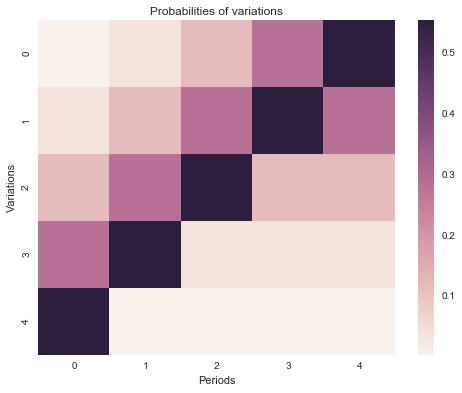

In [7]:
# p_true_periods = np.random.beta(1, 3, size=(n_variations, n_switches))
p_true_periods /= p_true_periods.sum(axis=0)

ax = sns.heatmap(p_true_periods)
ax.set(xlabel='Periods', ylabel='Variations', title='Probabilities of variations')
plt.show()

In [8]:
p_true_periods

array([[ 0.00444444,  0.03555556,  0.12      ,  0.28444445,  0.55555558],
       [ 0.03555556,  0.12      ,  0.28444445,  0.55555558,  0.28444445],
       [ 0.12      ,  0.28444445,  0.55555558,  0.12      ,  0.12      ],
       [ 0.28444445,  0.55555558,  0.03555556,  0.03555556,  0.03555556],
       [ 0.55555558,  0.00444444,  0.00444444,  0.00444444,  0.00444444]], dtype=float32)

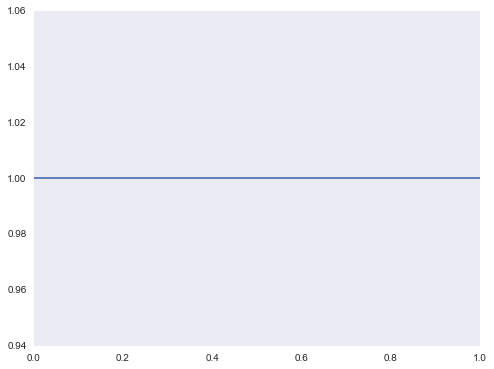

In [9]:
x_support = np.linspace(0, 1, 1000)
plt.plot(x_support, stats.beta.pdf(x_support, 1, 1))
plt.show()

Winner is 4
Level of winner: 0.00000000
4    783
3     74
2     49
1     48
0     46
dtype: int64


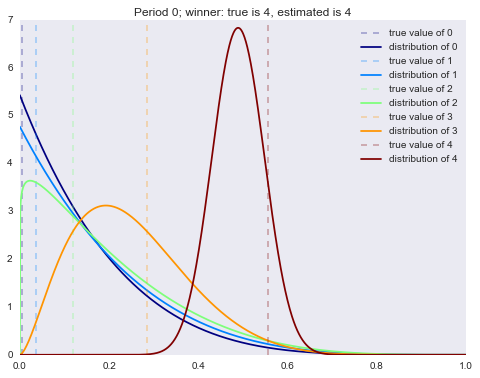

Winner is 4
Level of winner: 0.00000000
3    722
2    105
4     62
1     62
0     49
dtype: int64


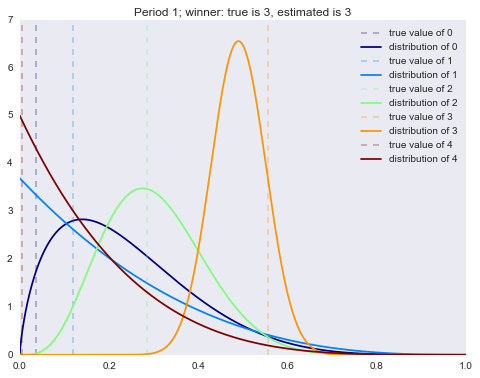

Winner is 4
Level of winner: 0.00000000
2    774
1     73
3     59
0     53
4     41
dtype: int64


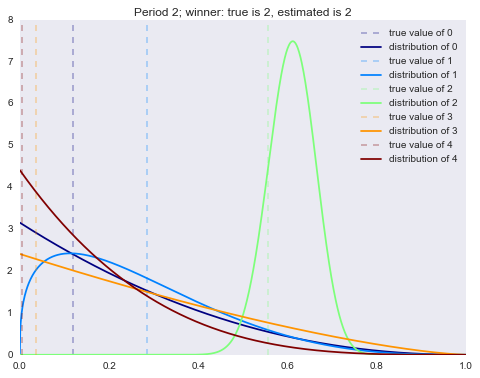

Winner is 4
Level of winner: 0.00000000
1    755
2     79
0     77
3     45
4     44
dtype: int64


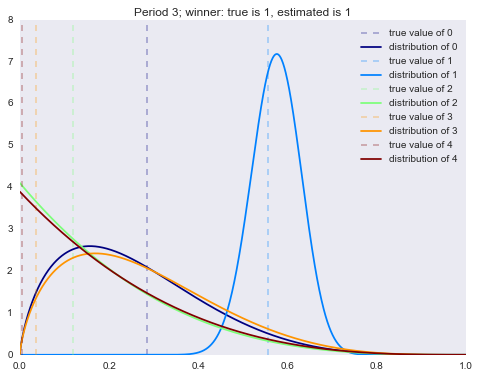

Winner is 4
Level of winner: 0.00000000
0    760
1    114
2     47
3     40
4     39
dtype: int64


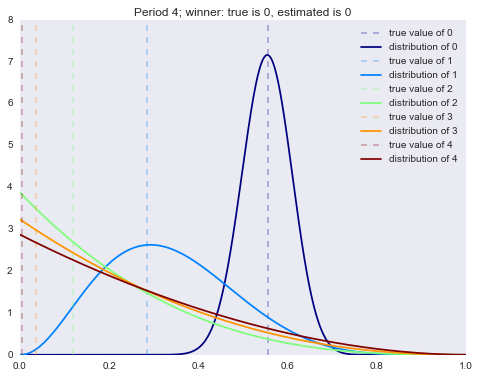

In [11]:
alpha = dict([(i, [1]) for i in range(n_variations)])
beta = dict([(i, [1]) for i in range(n_variations)])

decay = 0.99
expected_accuracy = 0

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n_variations)]

actionspp = []

for ix_period in range(p_true_periods.shape[1]):
    p_true = p_true_periods[:, ix_period]
    is_converged = False
    actions = []
    for ix_step in range(n_period_len):
        theta = dict([(i, np.random.beta(alpha[i][-1], beta[i][-1])) 
                      for i in range(n_variations)])
        k, theta_k = sorted(theta.items(), key=lambda t: t[1], reverse=True)[0]
        actions.append(k)
        
        x_k = np.random.binomial(1, p_true[k], size=1)[0]
        
        for i in range(n_variations):
            alpha[i].append(max(1, alpha[i][-1]*decay))
            beta[i].append(max(1, beta[i][-1]*decay))
        
        alpha[k].append(alpha[k][-1] + x_k)
        beta[k].append(beta[k][-1] + 1 - x_k)
    

    expected_reward = dict([(i, alpha[i][-1]/float(alpha[i][-1] + beta[i][-1])) 
                            for i in range(n_variations)])
    estimated_winner = sorted(expected_reward.items(), 
                              key=lambda t: t[1], 
                              reverse=True)[0][0]

    mu = alpha[estimated_winner][-1]/float(
        alpha[estimated_winner][-1] + beta[estimated_winner][-1])
    left, right = stats.beta.cdf(
        [mu - expected_accuracy, mu + expected_accuracy], 
        a=alpha[estimated_winner][-1], b=beta[estimated_winner][-1])
    level = right - left
        
    
    print 'Winner is %i' % i
    print 'Level of winner: %0.8f' % level
    actions_loc = pd.Series(actions).value_counts()
    print actions_loc
    actionspp.append(actions_loc.to_dict())
    
    for i in range(n_variations):
        plt.axvline(x=p_true[i], color=colors[i], linestyle='--', 
                    alpha=0.3, label='true value of %i' % i)
        
        plt.plot(x_support, stats.beta.pdf(x_support, alpha[i][-1], beta[i][-1]), 
                 label='distribution of %i' % i, color=colors[i])
    plt.legend()
    plt.title('Period %i; winner: true is %i, estimated is %i' % 
          (ix_period, 
           p_true.argmax(),
           estimated_winner))
    plt.show()

actionspp = dict(enumerate(actionspp))

In [69]:
actionspp

{0: {0: 8, 1: 7, 2: 19, 3: 49, 4: 917},
 1: {0: 1, 1: 3, 2: 3, 3: 674, 4: 319},
 2: {0: 3, 1: 1, 2: 408, 3: 420, 4: 168},
 3: {0: 1, 1: 269, 2: 489, 3: 106, 4: 135},
 4: {1: 972, 2: 12, 3: 9, 4: 7}}

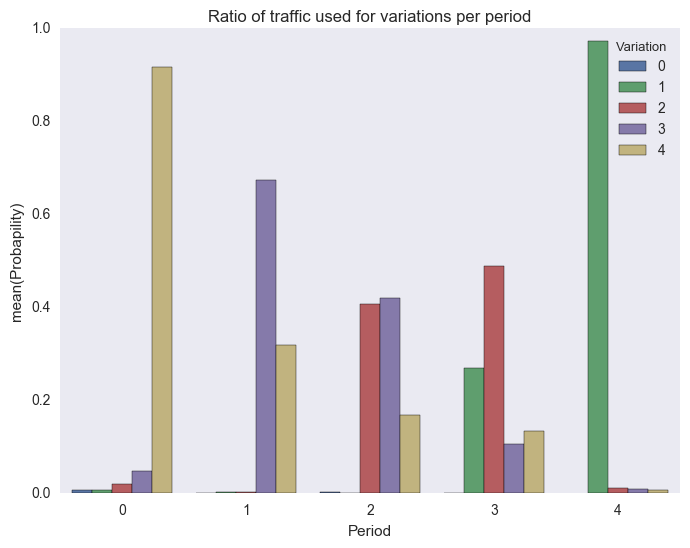

In [76]:
df = []
for pid in actionspp.keys():
    for vid in actionspp[pid].keys():
        df.append({
                'Period': pid,
                'Variation': vid,
                'Probapility': actionspp[pid][vid]/1000.0
            })
df = pd.DataFrame(df)

ax = sns.barplot(x="Period", y="Probapility", hue="Variation", data=df)
ax.set(title="Ratio of traffic used for variations per period")